Copyright (c) Microsoft Corporation. All rights reserved.
Licensed under the MIT License.
Modified by Shohei Nagata, 30 Mar 2021.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/ml-frameworks/pytorch/distributed-pytorch-with-horovod/distributed-pytorch-with-horovod.png)

# PyTorchの分散学習 (DistributedDataParallel版)


In this tutorial, you will train a PyTorch model on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset using distributed training with PyTorch's `DistributedDataParallel` module across a GPU cluster.

本日のハンズオンでは[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)データセットを対象に、PyTorchの`DistributedDataParallel`モジュールを用いてGPUクラスター間で分散学習を行い、PyTorchモデルを学習します。

## 前提条件確認 Prerequisites
* If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, go through the [Configuration](../../../../configuration.ipynb) notebook to install the Azure Machine Learning Python SDK and create an Azure ML `Workspace`

事前にAzure Machine Learning Python SDKをインストールし、Azure ML `Workspace`を作成してください。  
※Azure Machine Learning Notebook VMを使用している場合は、すべての設定が完了しています。

In [1]:
# Azure ML SDKのバージョン確認
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.25.0


## ワークスペースの設定 Initialize workspace
前提条件のステップで作成した既存のワークスペースから、[Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace)オブジェクトを初期化します。`Workspace.from_config()` は、`config.json` に格納された詳細情報から、ワークスペース・オブジェクトを作成します。   
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.  
事前にAzure ML Studioから構成ファイル (config.json)をダウンロードし、本スクリプトと同一階層に置きます。  

初回実行時は認証を行う必要があるため、実行結果部分の指示に従って https://microsoft.com/devicelogin にアクセスし、認証コードを入力します。

In [113]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code HD5SQB5AL to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Failed to authenticate to tenant '488ea627-1f1a-452d-8eb1-904f5c36ec3a' due to error 'Get Token request returned http error: 400 and server response: {"error":"interaction_required","error_description":"AADSTS50076: Due to a configuration change made by your administrator, or because you moved to a new location, you must use multi-factor authentication to access '797f4846-ba00-4fd7-ba43-dac1f8f63013'.\r\nTrace ID: f239daa5-9b35-4b5f-85b9-a29f94ef4400\r\nCorrelation ID: d8d7ebdf-5345-4fdc-87ef-cb6ce2baf6ce\r\nTimestamp: 2021-03-31 01:28:34Z","error_codes":[50076],"timestamp":"2021-03-31 01:28:34Z","trace_id":"f239daa5-9b35-4b5f-85b9-a29f94ef4400","correlation_id":"d8d7ebdf-5345-4fdc-87ef-cb6c

## 計算環境の準備 Create or attach existing AmlCompute

モデルをトレーニングするためには、[コンピューティング先](hhttps://docs.microsoft.com/ja-jp/azure/machine-learning/concept-azure-machine-learning-architecture#computes)を作成する必要があります。このノートブックでは、コンピューティング クラスターをリモートトレーニング用のコンピュートリソースとして使用します。  
具体的には，以下のコードで，`STANDARD_NC6`のGPUクラスターを作成し，`0`から`4`のノードにオートスケールします。

**コンピューティングクラスターの作成には約5分かかります。** 同一名称のものがワークスペースにある場合、下記コードは作成プロセスをスキップします。

他のAzureサービスと同様に、Azure Machine Learningサービスに関連する特定のリソース（コンピューティング インスタンス、コンピューティング クラスターなど）には制限があります。  
参考：[Azure Machine Learning を使用するリソースのクォータの管理と引き上げ](https://docs.microsoft.com/ja-jp/azure/machine-learning/how-to-manage-quotas)、
[申請手順](https://docs.microsoft.com/ja-jp/azure/azure-portal/supportability/regional-quota-requests#request-a-quota-increase-by-region-from-help--support)

You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, we use Azure ML managed compute ([AmlCompute](https://docs.microsoft.com/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute)) for our remote training compute resource. Specifically, the below code creates an `STANDARD_NC6` GPU cluster that autoscales from `0` to `4` nodes.

**Creation of AmlCompute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace, this code will skip the creation process.

As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = 'gpu-cluster'

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6',
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

# use get_status() to get a detailed status for the current AmlCompute. 
print(compute_target.get_status().serialize())

Found existing compute target.
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-03-23T03:45:29.543000+00:00', 'errors': None, 'creationTime': '2021-03-22T09:03:01.130767+00:00', 'modifiedTime': '2021-03-22T09:03:16.578884+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


The above code creates GPU compute. If you instead want to create CPU compute, provide a different VM size to the `vm_size` parameter, such as `STANDARD_D2_V2`.

## データセットの準備 Prepare dataset

Prepare the dataset used for training. We will first download and extract the publicly available CIFAR-10 dataset from the cs.toronto.edu website and then create an Azure ML FileDataset to use the data for training.

### Download and extract CIFAR-10 data

In [5]:
import urllib
import tarfile
import os

url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = 'cifar-10-python.tar.gz'
data_root = 'cifar-10'
filepath = os.path.join(data_root, filename)

if not os.path.isdir(data_root):
    os.makedirs(data_root, exist_ok=True)
    urllib.request.urlretrieve(url, filepath)
    with tarfile.open(filepath, "r:gz") as tar:
        tar.extractall(path=data_root)
    os.remove(filepath)  # delete tar.gz file after extraction

### Create Azure ML dataset

The `upload_directory` method will upload the data to a datastore and create a FileDataset from it. In this tutorial we will use the workspace's default datastore.

In [6]:
from azureml.core import Dataset

datastore = ws.get_default_datastore()
dataset = Dataset.File.upload_directory(
    src_dir=data_root, target=(datastore, data_root)
)

Method upload_directory: This is an experimental method, and may change at any time.<br/>For more information, see https://aka.ms/azuremlexperimental.
Validating arguments.
Arguments validated.
Uploading file to cifar-10
Uploading an estimated of 8 files
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/data_batch_5
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/batches.meta
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/test_batch
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/data_batch_4
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/data_batch_3
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/data_batch_1
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/readme.html
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/data_batch_2
Uploaded 0 files
Creating new dataset


## モデル学習 Train model on the remote compute
Now that we have the AmlCompute ready to go, let's run our distributed training job.

### Create a project directory
Create a directory that will contain all the necessary code from your local machine that you will need access to on the remote resource. This includes the training script and any additional files your training script depends on.

In [7]:
project_folder = './pytorch-distr'
os.makedirs(project_folder, exist_ok=True)

### Prepare training script
Now you will need to create your training script. In this tutorial, the script for distributed training on CIFAR-10 is already provided for you at `train.py`. In practice, you should be able to take any custom PyTorch training script as is and run it with Azure ML without having to modify your code.

Once your script is ready, copy the training script `train.py` into the project directory.
トレーニングスクリプトをプロジェクトディレクトリ内へコピーします。

In [38]:
import shutil

shutil.copy('train.py', project_folder)

'./pytorch-distr/train.py'

### Create an experiment
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) to track all the runs in your workspace for this distributed PyTorch tutorial. 
実験を設定します。

In [9]:
from azureml.core import Experiment

experiment_name = 'pytorch-distr'
experiment = Experiment(ws, name=experiment_name)

### Create an environment

In this tutorial, we will use one of Azure ML's curated PyTorch environments for training. [Curated environments](https://docs.microsoft.com/azure/machine-learning/how-to-use-environments#use-a-curated-environment) are available in your workspace by default. Specifically, we will use the PyTorch 1.6 GPU curated environment.  

Azure MLではいくつかの[キュレートされた実行環境](https://docs.microsoft.com/ja-jp/azure/machine-learning/how-to-use-environments#use-a-curated-environment)が用意されています。
今回はPyTorch 1.6 GPU環境を使用します。こちらのキュレートされた環境には今回のトレーニングスクリプトで必要なtorch, torchvisionも含まれています。

参考：[キュレーションされた環境一覧](https://docs.microsoft.com/ja-jp/azure/machine-learning/resource-curated-environments)

In [42]:
from azureml.core import Environment

pytorch_env = Environment.get(ws, name='AzureML-PyTorch-1.6-GPU')

In [64]:
# 中身の確認
print(pytorch_env.python.conda_dependencies.serialize_to_string())

channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-core==1.18.0.post1
  - azureml-defaults==1.18.0
  - azureml-telemetry==1.18.0
  - azureml-train-restclients-hyperdrive==1.18.0
  - azureml-train-core==1.18.0
  - cmake==3.18.2
  - torch==1.6.0
  - torchvision==0.5.0
  - mkl==2018.0.3
  - horovod==0.20.0
  - tensorboard==1.14.0
  - future==0.17.1
name: azureml_9d2a515d5c77954f2d0562cc5eb8a1fc



### Configure the training job

To launch a distributed PyTorch job on Azure ML, you have two options:

1. Per-process launch - specify the total # of worker processes (typically one per GPU) you want to run, and
Azure ML will handle launching each process.
2. Per-node launch with [torch.distributed.launch](https://pytorch.org/docs/stable/distributed.html#launch-utility) - provide the `torch.distributed.launch` command you want to
run on each node.

For more information, see the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-train-pytorch#distributeddataparallel).

Both options are shown below.

#### Per-process launch

To use the per-process launch option in which Azure ML will handle launching each of the processes to run your training script,

1. Specify the training script and arguments
2. Create a `PyTorchConfiguration` and specify `node_count` and `process_count`. The `process_count` is the total number of processes you want to run for the job; this should typically equal the # of GPUs available on each node multiplied by the # of nodes. Since this tutorial uses the `STANDARD_NC6` SKU, which has one GPU, the total process count for a 2-node job is `2`. If you are using a SKU with >1 GPUs, adjust the `process_count` accordingly.

Azure ML will set the `MASTER_ADDR`, `MASTER_PORT`, `NODE_RANK`, `WORLD_SIZE` environment variables on each node, in addition to the process-level `RANK` and `LOCAL_RANK` environment variables, that are needed for distributed PyTorch training.

In [43]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import PyTorchConfiguration

# create distributed config
distr_config = PyTorchConfiguration(process_count=2, node_count=2)

# create args
args = ["--data-dir", dataset.as_download(), "--epochs", 25]

# create job config
src = ScriptRunConfig(source_directory=project_folder,
                      script='train.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=pytorch_env,
                      distributed_job_config=distr_config)

#### Per-node launch with `torch.distributed.launch`

If you would instead like to use the PyTorch-provided launch utility `torch.distributed.launch` to handle launching the worker processes on each node, you can do so as well. 

1. Provide the launch command to the `command` parameter of ScriptRunConfig. For PyTorch jobs Azure ML will set the `MASTER_ADDR`, `MASTER_PORT`, and `NODE_RANK` environment variables on each node, so you can simply just reference those environment variables in your command. If you are using a SKU with >1 GPUs, adjust the `--nproc_per_node` argument accordingly.

2. Create a `PyTorchConfiguration` and specify the `node_count`. You do not need to specify the `process_count`; by default Azure ML will launch one process per node to run the `command` you provided.

Uncomment the code below to configure a job with this method.

In [ ]:
'''
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import PyTorchConfiguration

# create distributed config
distr_config = PyTorchConfiguration(node_count=2)

# define command
launch_cmd = ["python -m torch.distributed.launch --nproc_per_node 1 --nnodes 2 " \
    "--node_rank $NODE_RANK --master_addr $MASTER_ADDR --master_port $MASTER_PORT --use_env " \
    "train.py --data-dir", dataset.as_download(), "--epochs 25"]

# create job config
src = ScriptRunConfig(source_directory=project_folder,
                      command=launch_cmd,
                      compute_target=compute_target,
                      environment=pytorch_env,
                      distributed_job_config=distr_config)
'''

### トレーニングジョブの実行 (送信)
前セルの`ScriptRunConfig`で設定した条件に基づいて実験を実行 (送信)します。
Run your experiment by submitting your `ScriptRunConfig` object. Note that this call is asynchronous.

In [44]:
run = experiment.submit(src)
print(run)

Run(Experiment: pytorch-distr,
Id: pytorch-distr_1617070361_76d0aa71,
Type: azureml.scriptrun,
Status: Preparing)


### モニタリング
You can monitor the progress of the run with a Jupyter widget. Like the run submission, the widget is asynchronous and provides live updates every 10-15 seconds until the job completes. You can see that the widget automatically plots and visualizes the loss metric that we logged to the Azure ML run.

Jupyterウィジェットを使って実行の進捗状況を監視することができます。実行のサブミッションと同様に、ウィジェットは非同期で、ジョブが完了するまで10～15秒ごとに自動で更新されます。ウィジェットでは、Azure MLの実行に記録した損失指標が自動的に表示・可視化されます。

※VSCode上で実行する場合、テーマ設定 (背景色)によってはAzure MLウィジェットが見えにくくなる可能性があります。その場合はLightテーマの使用をお勧めします。

In [114]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

また、スクリプトのトレーニングが完了するまでノートブックの実行をブロックしてから、さらにそれ以降のコードを実行していく形にもできます。

In [46]:
run.wait_for_completion(show_output=True) # this provides a verbose log

RunId: pytorch-distr_1617070361_76d0aa71
Web View: https://ml.azure.com/runs/pytorch-distr_1617070361_76d0aa71?wsid=/subscriptions/f57ce3c6-5c6f-4f1e-8cba-b782d8974590/resourcegroups/rg-aml/workspaces/ml-lab&tid=72f988bf-86f1-41af-91ab-2d7cd011db47

Streaming azureml-logs/65_job_prep-tvmps_70b6890346015bc915416859fb4c2b96e3f18624ff430d2fb8e27bc7358d61aa_d.txt

[2021-03-30T02:17:20.271641] Entering job preparation.
[2021-03-30T02:17:20.783806] Starting job preparation.
[2021-03-30T02:17:20.783844] Extracting the control code.
[2021-03-30T02:17:20.790138] fetching and extracting the control code on master node.
[2021-03-30T02:17:20.790163] Starting extract_project.
[2021-03-30T02:17:20.790193] Starting to extract zip file.
[2021-03-30T02:17:21.438495] Finished extracting zip file.
[2021-03-30T02:17:21.606756] Using urllib.request Python 3.0 or later
[2021-03-30T02:17:21.606814] Start fetching snapshots.
[2021-03-30T02:17:21.606855] Start fetching snapshot.
[2021-03-30T02:17:21.606871] Re

{'runId': 'pytorch-distr_1617070361_76d0aa71',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-03-30T02:16:57.267905Z',
 'endTimeUtc': '2021-03-30T02:29:23.967689Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '045927a0-df79-455a-9e73-27de45de22d1',
  'azureml.git.repository_uri': 'git@github.com:shohei1029/azureml_distributed-pytorch.git',
  'mlflow.source.git.repoURL': 'git@github.com:shohei1029/azureml_distributed-pytorch.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '26e588cedaeed49e79d8b52b98e6c69d45fe1b8c',
  'mlflow.source.git.commit': '26e588cedaeed49e79d8b52b98e6c69d45fe1b8c',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '5552c1f0-d54d-4c12-9dea-c3c6d08c5c4f'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input_

## モデルの登録


In [47]:
#実行に関係しているファイル一覧の表示
for i in run.get_file_names():
    print(i)

azureml-logs/55_azureml-execution-tvmps_70b6890346015bc915416859fb4c2b96e3f18624ff430d2fb8e27bc7358d61aa_d.txt
azureml-logs/55_azureml-execution-tvmps_cd1cec81acfb1f5ae9cacf052331a2ab34bbc547f3c9631f2ab255b657b4924c_d.txt
azureml-logs/65_job_prep-tvmps_70b6890346015bc915416859fb4c2b96e3f18624ff430d2fb8e27bc7358d61aa_d.txt
azureml-logs/65_job_prep-tvmps_cd1cec81acfb1f5ae9cacf052331a2ab34bbc547f3c9631f2ab255b657b4924c_d.txt
azureml-logs/70_driver_log_0.txt
azureml-logs/70_driver_log_1.txt
azureml-logs/75_job_post-tvmps_70b6890346015bc915416859fb4c2b96e3f18624ff430d2fb8e27bc7358d61aa_d.txt
azureml-logs/75_job_post-tvmps_cd1cec81acfb1f5ae9cacf052331a2ab34bbc547f3c9631f2ab255b657b4924c_d.txt
azureml-logs/process_info.json
azureml-logs/process_status.json
logs/azureml/0_110_azureml.log
logs/azureml/1_89_azureml.log
logs/azureml/dataprep/backgroundProcess.log
logs/azureml/dataprep/backgroundProcess_Telemetry.log
logs/azureml/job_prep_azureml.log
logs/azureml/job_release_azureml.log
logs/azure

In [48]:
model = run.register_model(model_name = 'pytorch-distr', model_path = 'outputs/cifar_net.pt')
print(model.name, model.id, model.version, sep = '\t')

pytorch-distr	pytorch-distr:3	3


## モデルデプロイ
Azure Container Instances (ACI) にモデルをWebサービスとしてモデルをデプロイしていきます。  
参考：[Azure Container Instances とは](https://docs.microsoft.com/ja-jp/azure/container-instances/container-instances-overview)

### スコアリングスクリプトの作成
Web サービスの呼び出しに使用される score.py というスコアリング スクリプトを作成してモデルの使用方法を示します。
スコアリング スクリプトには、2 つの必要な関数を含める必要があります。
- `init()` 関数。通常、グローバル オブジェクトにモデルを読み込みます。 この関数は、Docker コンテナーを開始するときに 1 回だけ実行されます。
- `run(input_data)` 関数。モデルを使用して、入力データに基づく値を予測します。 実行に対する入力と出力は、通常、JSON を使用してシリアル化およびシリアル化解除が実行されますが、その他の形式もサポートされています。

In [109]:
%%writefile score.py
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from azureml.core.model import Model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 6 * 6, 120)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 6 * 6)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'cifar_net.pt')
    model = Net()    
    model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
    model.eval()

def run(input_data):
    input_data = torch.tensor(json.loads(input_data)['data'])

    # get prediction
    with torch.no_grad():
        output = model(input_data)
        classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        softmax = nn.Softmax(dim=1)
        pred_probs = softmax(output).numpy()[0]

        print("outputです：", output) # output中身確認. n x 10 の行列(リスト入れ子)型tensor

        index = torch.argmax(output, 1) # 元コードで使われていたもの。dim=1がついている
        print("indexです：", index) # 81要素のリスト型tensor

        # index = torch.argmax(output) # dim=1を消したものに置き換えてみた
        # print("indexです：", index) #要素1個。

    result = {"label": classes[index], "probability": str(pred_probs[index])}
    return result

Overwriting score.py


### ACIコンテナへのデプロイ
デプロイの構成ファイルを作成し、ACI コンテナーに必要な CPU 数と RAM ギガバイト数を指定します。 実際のモデルにもよりますが、通常、多くのモデルには既定値の 1 コアと 1 ギガバイトの RAM で十分です。 後でもっと必要になった場合は、イメージを再作成し、サービスをデプロイし直す必要があります。
※今回はデプロイ先の実行環境にはトレーニング時と同一の環境を使用しています。

#### デプロイ先conda環境設定
(ACI推論用に別環境を設定。(学習用と同じ環境だとデプロイ時にエラーが発生したため))

In [66]:
%%writefile conda_dependencies_deploy.yml

channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
#   - azureml-core==1.18.0.post1
#   - azureml-defaults==1.18.0
  - azureml-defaults
  - torch==1.6.0
  - torchvision==0.7.0
  - future==0.17.1
  - pillow

Overwriting conda_dependencies_deploy.yml


In [67]:
from azureml.core import Environment

aci_pytorch_env = Environment.from_conda_specification(name = 'pytorch-1.6-deploy', file_path = './conda_dependencies_deploy.yml')

# # Specify a GPU base image これは学習用かな
# pytorch_env.docker.enabled = True
# pytorch_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04'

In [22]:
# #GPU有効化だけしてデプロイ試してみる。仮コード
# pytorch_env.docker.enabled = True
# pytorch_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04'

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


In [115]:
%%time
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model

#推論スクリプト・環境の指定
inference_config = InferenceConfig(entry_script="score.py", environment=aci_pytorch_env) # デプロイ用環境を別で使用する場合。成功
# inference_config = InferenceConfig(entry_script="score.py", environment=pytorch_env) # 学習時と同じ環境を使用する場合

#デプロイの構成設定
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'data': 'cifar-10',  'model':'pytorch-distr', 'framework':'pytorch'},
                                               description='Classify daily objects from the cifar-10 dataset using PyTorch')

# model = Model(ws, 'pytorch-distr')

service = Model.deploy(workspace=ws, 
                           name='aci-cifar10', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig,
                           overwrite=True)

service.wait_for_deployment(show_output=True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-03-31 10:31:37+09:00 Creating Container Registry if not exists.
2021-03-31 10:31:38+09:00 Use the existing image.
2021-03-31 10:31:39+09:00 Generating deployment configuration.
2021-03-31 10:31:39+09:00 Submitting deployment to compute.
2021-03-31 10:31:42+09:00 Checking the status of deployment aci-cifar10..
2021-03-31 10:37:59+09:00 Checking the status of inference endpoint aci-cifar10.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
CPU times: user 5.21 s, sys: 499 ms, total: 5.71 s
Wall time: 6min 29s


In [116]:
# デプロイ中に問題が発生した場合にログ取得
service.get_logs()

'/bin/bash: /azureml-envs/azureml_c6cc06fa78f35a468caab22f5d54e724/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n/bin/bash: /azureml-envs/azureml_c6cc06fa78f35a468caab22f5d54e724/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n/bin/bash: /azureml-envs/azureml_c6cc06fa78f35a468caab22f5d54e724/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n/bin/bash: /azureml-envs/azureml_c6cc06fa78f35a468caab22f5d54e724/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n2021-03-31T01:37:39,860045000+00:00 - gunicorn/run \n2021-03-31T01:37:39,870751300+00:00 - rsyslog/run \n2021-03-31T01:37:39,877334600+00:00 - iot-server/run \nbash: /azureml-envs/azureml_c6cc06fa78f35a468caab22f5d54e724/lib/libtinfo.so.5: no version information available (required by bash)\n2021-03-31T01:37:39,909008800+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_c6cc06fa78f35a468caab22f5d54e724/lib/libcrypt

In [72]:
# 再デプロイ前に既存のACIサービスを削除
service.delete()

## Webサービスのテスト
最後に、デプロイしたWebサービスをテストしてみましょう。ACIにホストされているWebサービスにJSON文字列としてデータを送信し、SDKのrun APIを使ってサービスを呼び出してみます。ここでは、検証データから画像を取り出して予測を行います。
  
メモ：notebook conda環境に下記のライブラリ入れる必要あるかも。

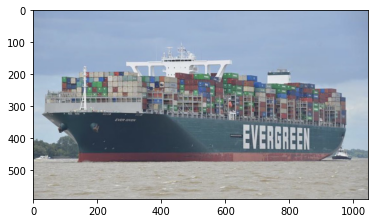

In [96]:
#テスト用画像の表示
import json
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
plt.imshow(Image.open('test_img.jpg'))

In [97]:
#画像の前処理関数の定義
import torch
from torchvision import transforms

def preprocess(image_file):
    """Preprocess the input image."""
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_file)
    image = data_transforms(image).float()
    image = torch.tensor(image)
    image = image.unsqueeze(0)
    return image.numpy()

In [117]:
#Webサービスに画像を投げ、推論結果を取得
input_data = preprocess('test_img.jpg')

# test_sample = json.dumps({'data': input_data.tolist()})
# test_sample = bytes(test_sample, encoding = 'utf8')
# result = service.run(input_data=test_sample)
result = service.run(input_data=json.dumps({'data': input_data.tolist()}))
print(result)

/home/shohei/.anyenv/envs/pyenv/versions/anaconda3-2020.11/envs/azureml_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
Received bad response from service. More information can be found by calling `.get_logs()` on the webservice object.
Response Code: 502
Headers: {'Connection': 'keep-alive', 'Content-Length': '24', 'Content-Type': 'text/html; charset=utf-8', 'Date': 'Wed, 31 Mar 2021 01:38:13 GMT', 'Server': 'nginx/1.10.3 (Ubuntu)', 'X-Ms-Request-Id': '96b00c2d-5a15-4399-905b-81c75ed92fbc', 'X-Ms-Run-Function-Failed': 'True'}
Content: b'tuple index out of range'



WebserviceException: WebserviceException:
	Message: Received bad response from service. More information can be found by calling `.get_logs()` on the webservice object.
Response Code: 502
Headers: {'Connection': 'keep-alive', 'Content-Length': '24', 'Content-Type': 'text/html; charset=utf-8', 'Date': 'Wed, 31 Mar 2021 01:38:13 GMT', 'Server': 'nginx/1.10.3 (Ubuntu)', 'X-Ms-Request-Id': '96b00c2d-5a15-4399-905b-81c75ed92fbc', 'X-Ms-Run-Function-Failed': 'True'}
Content: b'tuple index out of range'
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Received bad response from service. More information can be found by calling `.get_logs()` on the webservice object.\nResponse Code: 502\nHeaders: {'Connection': 'keep-alive', 'Content-Length': '24', 'Content-Type': 'text/html; charset=utf-8', 'Date': 'Wed, 31 Mar 2021 01:38:13 GMT', 'Server': 'nginx/1.10.3 (Ubuntu)', 'X-Ms-Request-Id': '96b00c2d-5a15-4399-905b-81c75ed92fbc', 'X-Ms-Run-Function-Failed': 'True'}\nContent: b'tuple index out of range'"
    }
}

In [118]:
# 問題が発生した場合にログ取得
service.get_logs()

,  5.3959e+00, -2.8565e+00,  5.3367e+00,\n         -6.0317e+00,  8.6048e+00, -8.1129e+00, -8.0301e+00,  8.9590e-01],\n        [-5.7830e-01,  2.0886e+00,  2.1267e+00,  9.1687e+00, -3.5051e+00,\n          2.1147e+00, -8.5009e+00, -1.4651e+00, -3.1183e+00, -1.5037e-01],\n        [ 2.3455e+00, -1.7610e+00,  5.6144e-01,  2.0704e+00,  2.3218e-01,\n          5.4984e-01, -1.8948e+00, -6.8330e-01, -1.3495e-01, -1.9759e+00],\n        [-3.1008e+00, -1.1414e+00,  1.0872e+00,  2.3123e+00,  2.9273e+00,\n          2.7107e-01, -1.0107e+00, -3.0508e+00, -1.7489e+00,  2.0593e+00],\n        [ 2.0286e+00,  3.2468e+00, -1.8158e+00,  3.4693e+00, -1.1787e+00,\n         -2.5792e+00, -2.9005e+00, -4.3407e+00,  6.9175e-01,  2.3874e+00],\n        [ 6.8400e+00, -2.6005e-01,  2.4063e+00,  6.0110e+00, -3.5205e+00,\n          3.7756e+00, -8.9992e+00, -1.5444e+00, -3.3754e+00, -2.7710e+00],\n        [ 1.5713e+00,  8.3821e-01,  2.2357e+00,  3.0640e+00, -3.3578e+00,\n          1.2045e-01, -2.0061e+00, -1.9416e+00,  9.4

## クリーンアップ
最後に、デプロイされたWebサービスを削除します。

In [ ]:
service.delete()